In [1]:
import numpy as np
import scipy.stats as ss
from numpy import Inf
import matplotlib.pyplot as plt
import sys
import pyEXP
from scipy.stats import binned_statistic_2d, binned_statistic
##  exp
#sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la

In [93]:
from scipy.optimize import curve_fit,leastsq
sech = lambda z_: np.power(np.cosh(z_),-1)
Iz = lambda zz,hz,Io: Io* np.power(sech(zz/hz),2)
def HeightPro(z,m,p0=None,bounds=((-np.inf,0),(np.inf,np.inf))):
        sech = lambda z_: np.power(np.cosh(z_),-1)
        Iz = lambda zz,hz,Io: Io* np.power(sech(zz/hz),2)
        mmax,mstd= np.max(m),np.std(m)
        bounds=((-np.inf,mmax-mstd),(np.inf,mmax+mstd))
        popt,pcov = curve_fit(Iz,z,m,bounds=bounds)
        hz,Io = popt
        fit_err=np.sqrt(np.diag(pcov))
        Z_fit =Iz(z,hz,Io)
        residuals = m - Z_fit
        chi_sq = sum((residuals**2)/Z_fit)

        Lib = {'h_z':hz,'I0':Io,
                'SechFit':(z,Z_fit),
                'ChiSquare':chi_sq, 'pcov':pcov}
        return Lib

def RMS(r,z,m,boxl=0.5,lmin=0,lmax=50):
    rbin=np.arange(lmin,lmax,boxl)
    ZM,_,_ =binned_statistic(r,(z**2),statistic='sum',bins=rbin)
    #M,_,_  =binned_statistic(r,m,statistic='sum',bins=rbin)
    c,_,_ = binned_statistic(r,z,statistic='count',bins=rbin)
    Z2 = ZM/c
    return rbin,np.sqrt(Z2)

In [84]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir = sim.sf.data['frc2'][0]*1000*sc/h
Mvir = sim.sf.data['fmc2'][0]*1e10/h
Npart = sim.sf.data['slty'][0]
Rhalf = sim.sf.data['shmt'][0][4]*1000*sc/h
print(Mvir,Rvir,Npart,Rhalf)


fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = np.float64(DatDM['pot'])
pos = np.float64(DatDM['pos']) #part_rot[not_in_subs]
mass = np.float64(np.ones_like(pos[:,0]))#DatDM['mass']  #part['dark']['mass'][not_in_subs]

poss,masss=Datstars['pos'],Datstars['mass']
print(type(mass[0]))

2088654433553.4023 349.25210558595916 [11792260 31503466        0        0 19107866        1] 12.202755384113084


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


<class 'numpy.float64'>


In [85]:
def StellarDensity1D(R,f,boxl=0.5,lmin=0,lmax=50,mode='SD',Lt=None):
    #Flux = lambda m: 10.**(-0.4 * m)
    #kpc2arcsec = lambda x: (x*1000/10)*((180*60*60)/np.pi)
    #flux = Flux(f)

    rstar = R#np.sqrt(fstar[:,0]**2 + fstar[:,1]**2)
    #boxl,lmin,lmax = 0.5,0,50
    r = np.arange(lmin,lmax,boxl)

    #box_arcsec = (boxl*1000/10)*((180*60*60)/np.pi)
    #print(box_arcsec)
    c = 0
    sb = np.zeros( (r.size,2) )
    # Perfil de brillo superficial
    for i in range(r.size-1):
        ind = (r[i]<=rstar)&(rstar<r[i+1])
        sb[c,0] = r[i]
        if mode=='SD':sb[c,1] = (np.sum(f[ind]) ) / (np.pi*(r[i+1]**2 - r[i]**2) ) #Msun/kpc^2
        if mode=='SDz':
            #rmax=np.max(Pos[:,1][ind])
            sb[c,1] = (np.sum(f[ind]) ) / (boxl*Lt ) #Msun/kpc^2
        c+=1

    mvs = -2.5*np.log(sb[:,1])
    return sb[:,0],sb[:,1]

In [86]:

R2Ds = np.sqrt(poss[:,0]**2  + poss[:,1]**2)
cutz = np.abs(poss[:,2])<=10
cutr = (R2Ds>= 0.5*Rhalf)&(R2Ds<= 1.5*Rhalf)
Rsd,SD = StellarDensity1D(R2Ds[cutr&cutz],masss[cutr&cutz],boxl=0.25,lmin=0.5*Rhalf,lmax=1.5*Rhalf)
Zsd,SDz = StellarDensity1D(poss[:,2][cutr&cutz],masss[cutr&cutz],boxl=0.25,lmin=-10,lmax=10,mode='SDz',Lt=2*Rhalf)


Rbin,Z2 = RMS(R2Ds[cutz],poss[:,2][cutz],masss[cutz],boxl=0.25,lmin=0,lmax=15)
#print(Zsd,SDz)

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(0.0, 5.0)

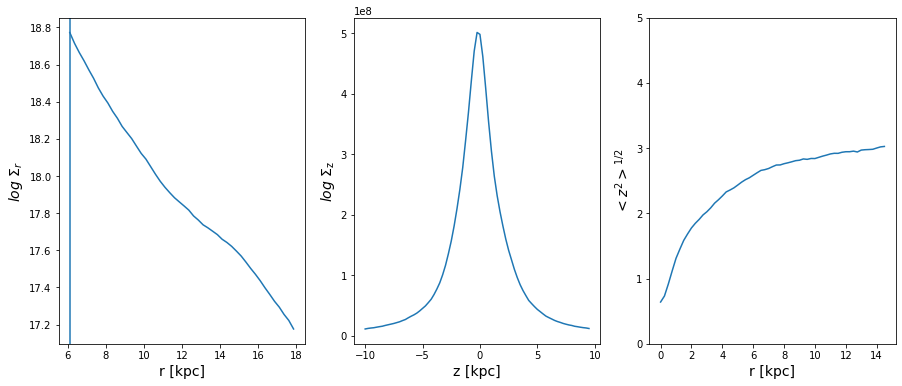

In [87]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.plot(Rsd,np.log(SD))
plt.axvline(0.5*Rhalf)
plt.xlabel('r [kpc]',fontsize=14)
plt.ylabel(r'$log\; \Sigma_r$',fontsize=14)

plt.subplot(132)
plt.plot(Zsd[:-1],SDz[:-1])
plt.xlabel('z [kpc]',fontsize=14)
plt.ylabel(r'$log\; \rm\Sigma_z$',fontsize=14)

plt.subplot(133)
plt.plot(Rbin[:-1],Z2)
plt.xlabel('r [kpc]',fontsize=14)
plt.ylabel(r'$<z^2>^{1/2}$',fontsize=14)
plt.ylim(0,5)


$\rm R_0$ and R --> $R_{max}$ both cases

$\rm M_0$ and M --> $M_{tot}$ and 1  (M are not same for star particles)

### $r_{fac} = \beta^{-0.25}\gamma^{-0.5} = R/R_0 = 1$

### $d_{fac} = \beta^{1.5}\gamma = \frac{M/M_0}{(R/R_0)^3} = M/M_0 = M^{-1}_{tot}$

so

### $s_{fac} = \frac{M/M_0}{(R/R_0)^2}= M^{-1}_{tot}$

In [94]:
import BreakFinder as bf
sfac = 1/np.sum(masss[cutz]) #superficial factor
#SD,SDz = SD*sfac,SDz*sfac

nonan = ~((np.log(SD)==np.inf)|(np.log(SD)==-np.inf))
cut=Rsd>=Rhalf*0.5
#rmax,zmax,SDrmax,SDzmax=Rsd.max(),10,np.log(SD[nonan&cut]).max(),SDz[:-1].max()



galaxy = bf.breaks(Rsd[nonan&cut],np.log(SD[nonan&cut]),Rsd[nonan&cut])


OneExp = galaxy.PureExp(bounds=((0,-np.inf),(np.inf,np.inf)))

bounds=((Rhalf,-np.inf,0,0),(Rsd.max(),np.inf,np.inf,np.inf))
DoubleExp = galaxy.DoubleExp(bounds=bounds)

nonanz = ~((np.log(SDz)==np.inf)|(np.log(SDz)==-np.inf))
Sechz = HeightPro(Zsd[:-1],SDz[:-1])

galz = bf.breaks(np.abs(Zsd[nonanz]),np.log(SDz[nonanz]),Zsd[nonanz])
ZExp = galz.PureExp(bounds=((-np.inf,-np.inf),(np.inf,np.inf)))

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


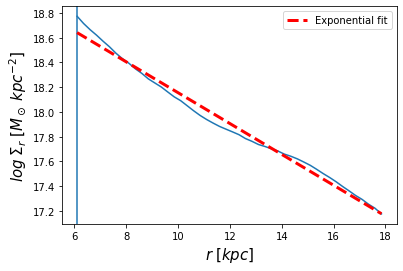

In [95]:
plt.plot(Rsd,np.log(SD))
plt.axvline(0.5*Rhalf)
plt.plot(OneExp['LineFit'][0],OneExp['LineFit'][1],c='r',lw=3,ls='--',label='Exponential fit')
plt.ylabel(r'$log\;\Sigma_r\; [M_\odot\;kpc^{-2}]$',fontsize=15)
plt.xlabel(r'$r\; [kpc]$',fontsize=15)
plt.legend()

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


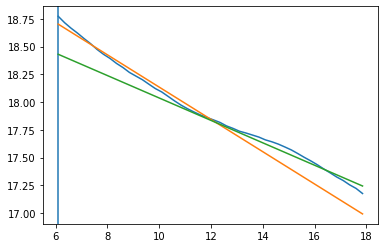

In [96]:
plt.plot(Rsd,np.log(SD))
plt.axvline(0.5*Rhalf)
plt.plot(DoubleExp['LineFit_in'][0],DoubleExp['LineFit_in'][1])
plt.plot(DoubleExp['LineFit_out'][0],DoubleExp['LineFit_out'][1])

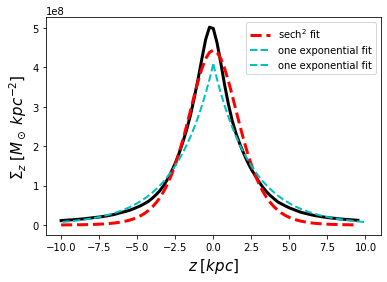

In [108]:
plt.plot(Zsd[:-1],SDz[:-1],lw=3,c='k')
plt.plot(Sechz['SechFit'][0][:-1],Sechz['SechFit'][1][:-1],lw=3,label=r'$\rm sech^2$ fit',c='r',ls='--')
plt.plot(ZExp['LineFit'][0],np.exp(ZExp['LineFit'][1]),lw=2,label='one exponential fit',c='c',ls='--')
plt.plot(-ZExp['LineFit'][0],np.exp(ZExp['LineFit'][1]),lw=2,label='one exponential fit',c='c',ls='--')
#plt.plot(Zsd[:-1],Iz(Zsd[:-1],Sechz['h_z'],SDz[:-1].max()),lw=3,label='exp mix')
plt.ylabel(r'$\Sigma_z\; [M_\odot\;kpc^{-2}]$',fontsize=15)
plt.xlabel(r'$z\; [kpc]$',fontsize=15)
plt.legend()

---

In [101]:
ferr=lambda p: np.sqrt(np.diag(p))
residuals = (SDz[:-1]) - (Sechz['SechFit'][1])
chi_sq = sum((residuals**2)/(Sechz['SechFit'][1]))
chi_sq
print('''
_______ For Sigma r ________
PureExp        \t\tstd
hr  %.3f\t[kpc]\t%.4f

DoubleExp
hi  %.3f\t[kpc]
ho  %.3f\t[kpc]\t%.4f\n
------ For Sigma z --------
Sech square
hz  %.3f\t[kpc]\t%.4f

absZ Exponential
hz  %.3f\t[kpc]\t%.4f
___________________'''%(OneExp['h_i'],ferr(OneExp['pcov'])[0],
                        DoubleExp['h_i'],DoubleExp['h_o'],ferr(DoubleExp['pcov'])[0],
                        Sechz['h_z'],ferr(Sechz['pcov'])[0],ZExp['h_i'],ferr(ZExp['pcov'])[0]))


_______ For Sigma r ________
PureExp        		std
hr  8.032	[kpc]	0.1386

DoubleExp
hi  6.872	[kpc]
ho  9.902	[kpc]	0.4437

------ For Sigma z --------
Sech square
hz  2.222	[kpc]	0.0571

absZ Exponential
hz  2.499	[kpc]	0.0463
___________________


In [102]:
Sechz['pcov'],ZExp['pcov']

(array([[ 3.25661420e-03, -3.24748982e+05],
        [-3.24748982e+05,  8.52300167e+13]]),
 array([[ 0.00213921, -0.00169239],
        [-0.00169239,  0.00178662]]))

diskpart = (np.abs(poss[:,2])<=10) &(R2Ds<= 1.5*Rhalf)

rrs = np.sqrt((poss[:,0]**2) + (poss[:,1]**2) + (poss[:,2]**2))[diskpart]

rrmin,rrmax=np.nanmin(rrs),np.nanmax(rrs)
rs,rhos = return_density(np.log10(rrs),weights= masss[diskpart], rangevals=[rrmin, rrmax],bins=100)
R,D,M,P,scal = makemodel_empirical(rs, rhos, "Au{}_disc_table.txt".format(nhalo),GetScaling=True)


"""
id         : cylinder
parameters :
  acyl       : 3.0 ASCALE
  hcyl       : 0.5 HSCALE
  mmax       : 2   MMAX
  ncylnx     : 128 NUMX
  ncylny     : 64  NUMY
  rnum       : 200 
  nmax       : 16  NORDER
  pnum       : 80  PNUM
  tnum       : 80  TNUM
  lmaxfid    : 10
  nmaxfid    : 10
  logr       : false LOGR
  density    : true  DENS
  eof_file   : CylGrid.cache.mwdisk
"""

In [63]:
disk_config = """
id: cylinder
parameters:
  acyl: 0.01
  hcyl: 0.001
  lmaxfid: 32
  mmax: 6
  nmaxfid: 32
  ncylnx: 256
  ncylny: 128
  rnum: 200
  pnum: 1
  tnum: 80
  ashift: 0.5
  vflag: 0
  logr: false
  density: false
  eof_file   : CylGrid.cache.mwdisk
"""

In [64]:
disk_basis = pyEXP.basis.Basis.factory(disk_config)

In [65]:
disk_basis.cacheInfo('CylGrid.cache.mwdisk')

RuntimeError: Execution exception: Error details: EmpCylSL::getHeader: invalid cache file <CylGrid.cache.mwdisk>.

In [59]:

Rmin = 0.0
Rmax = 0.1
Rnum = 200
Zmin = -0.03
Zmax =  0.03
Znum = 40

disk_grid = disk_basis.getBasis(Rmin, Rmax, Rnum, Zmin, Zmax, Znum)

In [60]:
disk_grid[0][0]['density']

array([[ 7.29111856e-304,  7.29111856e-304,  7.29111856e-304, ...,
        -4.73186405e+305, -1.98314546e+306, -2.39820234e+306],
       [ 7.29111856e-304, -2.39329233e+138, -1.10999866e+139, ...,
        -4.73186405e+305, -1.98314546e+306, -2.39820234e+306],
       [-7.17014027e+028, -1.02837130e+029, -2.45373487e+028, ...,
        -1.98730674e+306, -2.30960825e+306, -2.39820234e+306],
       ...,
       [ 7.29111856e-304,  7.29111856e-304,  7.29111856e-304, ...,
        -2.39820234e+306, -2.39820234e+306, -1.38271373e+306],
       [ 7.29111856e-304,  7.29111856e-304,  7.29111856e-304, ...,
        -2.39820234e+306, -2.39820234e+306, -1.38271373e+306],
       [ 7.29111856e-304,  7.29111856e-304,  7.29111856e-304, ...,
        -2.39820234e+306, -2.39820234e+306, -1.38271373e+306]])

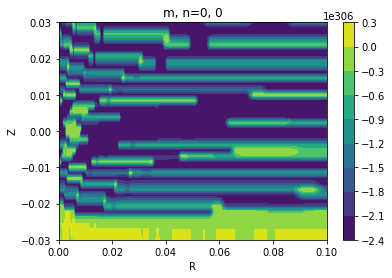

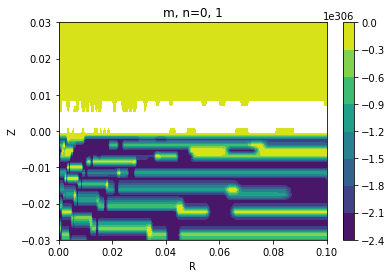

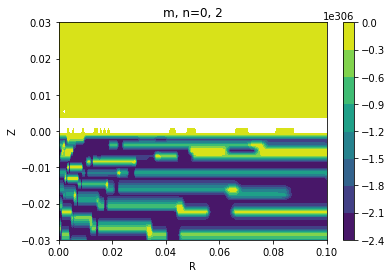

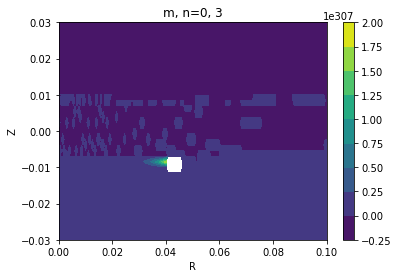

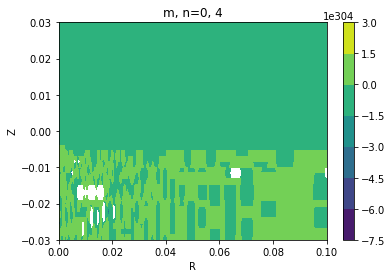

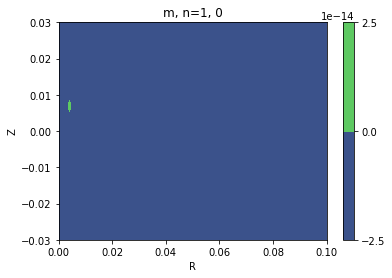

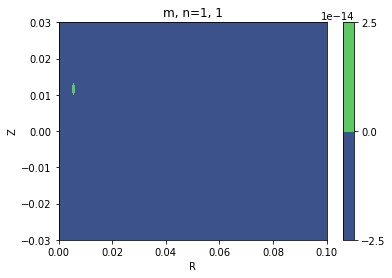

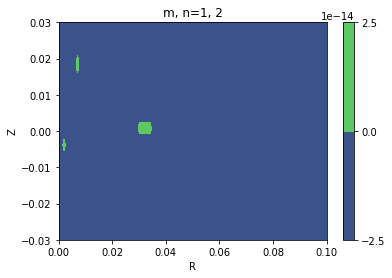

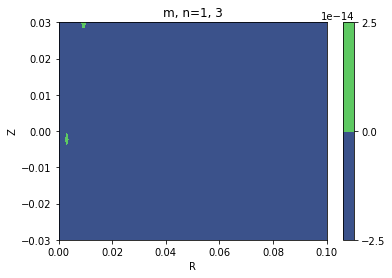

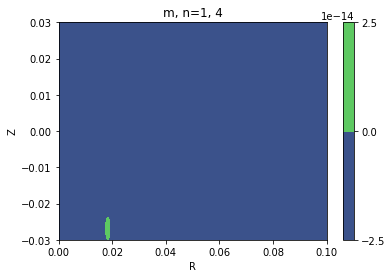

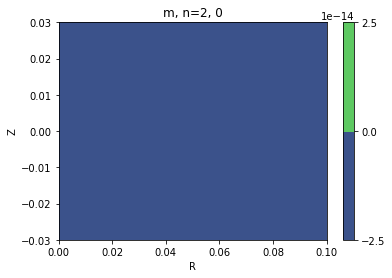

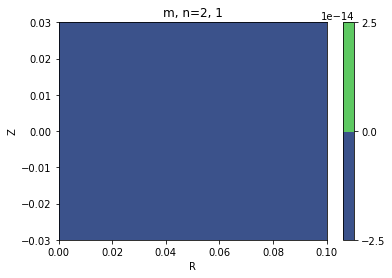

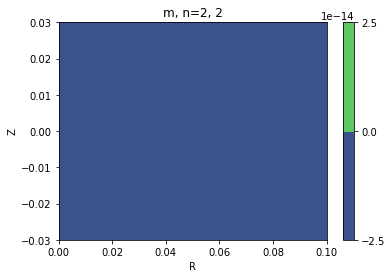

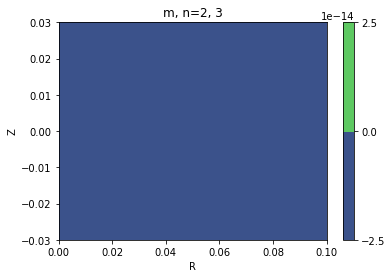

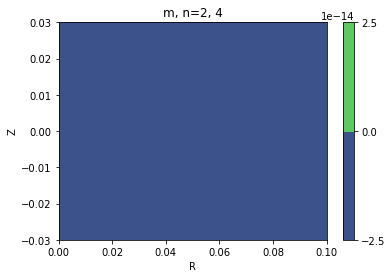

In [61]:
R = np.linspace(Rmin, Rmax, Rnum)
Z = np.linspace(-Zmax, Zmax, Znum)

xv, yv = np.meshgrid(R, Z)

for m in range(3):
    for n in range(5):
        # Tranpose for contourf
        cx = plt.contourf(xv, yv, disk_grid[m][n]['density'].transpose())
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.title('m, n={}, {}'.format(m, n))
        plt.colorbar(cx)
        plt.show()
    